Define the Scope:
1.Focus on Wi-Fi-based indoor positioning
2.Consider two types of attacks: Wi-Fi spoofing and signal strength manipulation

In [1]:
#Data Collection and Preprocessing:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

In [2]:
# Load and preprocess data
data = pd.read_csv('RSS - Kriging.csv')
data

,X,Y,RSS-A,RSS-B,RSS-C
0,0,2,49,73,69
1,0,3,50,70,70
2,0,4,50,68,70
3,0,5,51,68,71
4,0,6,52,67,70
...,...,...,...,...,...
198,6,26,62,65,51
199,6,27,61,65,51
200,6,28,60,65,51
201,6,29,61,65,51


In [13]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import RobustScaler

In [14]:
X = data.drop(['X', 'Y'], axis=1)  # Wi-Fi signal strengths
y = data[['X', 'Y']]  # Location coordinates

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [15]:


# Load training data
train_data = pd.read_csv("C:/Users/KIIT/Desktop/Adversial Geolocation/TRAIN_DATASET.csv")
X_train = train_data.drop(['X', 'Y'], axis=1)  # Wi-Fi signal strengths
y_train = train_data[['X', 'Y']]  # Location coordinates

# Load testing data
test_data = pd.read_csv("C:/Users/KIIT/Desktop/Adversial Geolocation/TEST_DATASET.csv")
X_test = test_data.drop(['X', 'Y'], axis=1)  # Wi-Fi signal strengths
y_test = test_data[['X', 'Y']]  # Location coordinates



In [16]:
# Normalize data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
#KAN implementation
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import Huber

def create_kan_model(input_shape, num_inner_functions=5, num_outer_functions=2):
    inputs = Input(shape=(input_shape,))
    
    # First layer: Inner functions
    inner_functions = []
    for _ in range(num_inner_functions):
        x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(inputs)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Dense(1, activation='linear')(x)
        inner_functions.append(x)
    
    # Concatenate inner functions
    concatenated = Concatenate()(inner_functions)
    
    # Second layer: Outer functions
    outer_functions = []
    for _ in range(num_outer_functions):
        x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(concatenated)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Dense(1, activation='linear')(x)
        outer_functions.append(x)
    
    # Final output
    outputs = Concatenate()(outer_functions)
    
    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=RMSprop(learning_rate=0.001), loss=Huber())
    
    return model

# Usage
input_shape = 44000  # Replace with your actual input shape
model = create_kan_model(input_shape)
base_model = create_kan_model(X_train.shape[1])
base_model.fit(X_train_scaled, y_train, epochs=10, batch_size=16, validation_split=0.2)

Epoch 1/10
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 2.5409 - val_loss: 1.0043
Epoch 2/10
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.3410 - val_loss: 0.9406
Epoch 3/10
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.3161 - val_loss: 0.6106
Epoch 4/10
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.3051 - val_loss: 0.7008
Epoch 5/10
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 0.2996 - val_loss: 0.7936
Epoch 6/10
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - loss: 0.3035 - val_loss: 0.8198
Epoch 7/10
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - loss: 0.2979 - val_loss: 0.8085
Epoch 8/10
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - loss: 0.2836 - val_loss: 0.8521
Epoch 9/10
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - loss: 0.2902 - val_loss: 0.7365
Epoch 10/10
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - loss: 0.2945 - val_loss: 0.9072


In [18]:
#Implement Adversarial Attacks:
def wifi_spoofing_attack(X, epsilon=0.1):
    """Simulate Wi-Fi spoofing by adding random noise"""
    return X + np.random.normal(0, epsilon, X.shape)

def signal_strength_manipulation(X, manipulation_factor=0.2):
    """Simulate signal strength manipulation"""
    return X * (1 + np.random.uniform(-manipulation_factor, manipulation_factor, X.shape))

In [19]:
#Evaluate Base Model Under Attacks:
def evaluate_under_attack(model, X, y, attack_func):
    X_attacked = attack_func(X)
    predictions = model.predict(X_attacked)
    mse = np.mean(np.sum((y - predictions)**2, axis=1))
    return np.sqrt(mse)

base_spoofing_error = evaluate_under_attack(base_model, X_test_scaled, y_test, wifi_spoofing_attack)
base_manipulation_error = evaluate_under_attack(base_model, X_test_scaled, y_test, signal_strength_manipulation)

print(f"Base Model Error under Wi-Fi Spoofing: {base_spoofing_error} meters")
print(f"Base Model Error under Signal Strength Manipulation: {base_manipulation_error} meters")

390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Base Model Error under Wi-Fi Spoofing: 2.3500068555398874 meters
Base Model Error under Signal Strength Manipulation: 2.3546747724842922 meters


In [21]:
#Implement Adversarial Training:
def adversarial_training_data(X, y, attack_funcs, attack_probs):
    X_adv = X.copy()
    for i in range(len(X)):
        attack = np.random.choice(attack_funcs, p=attack_probs)
        X_adv[i] = attack(X[i].reshape(1, -1)).flatten()
    return X_adv

X_train_adv = adversarial_training_data(X_train_scaled, y_train, 
                                        [wifi_spoofing_attack, signal_strength_manipulation],
                                        [0.4, 0.6])  # 20% chance of no attack

robust_model = create_kan_model(X_train.shape[1])
robust_model.fit(np.vstack([X_train_scaled, X_train_adv]), 
                 np.vstack([y_train, y_train]), 
                 epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 2.0612 - val_loss: 0.2100
Epoch 2/10
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.2362 - val_loss: 0.1186
Epoch 3/10
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.2150 - val_loss: 0.1020
Epoch 4/10
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.2143 - val_loss: 0.0975
Epoch 5/10
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.2105 - val_loss: 0.1126
Epoch 6/10
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.1986 - val_loss: 0.0705
Epoch 7/10
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.2027 - val_loss: 0.0944
Epoch 8/10
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.1981 - val_loss: 0.1062
Epoch 9/10
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.2015 - val_loss: 0.1232
Epoch 10/10
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.1959 - val_loss: 0.0865


In [23]:
#Evaluate Robust Model:
robust_spoofing_error = evaluate_under_attack(robust_model, X_test_scaled, y_test, wifi_spoofing_attack)
robust_manipulation_error = evaluate_under_attack(robust_model, X_test_scaled, y_test, signal_strength_manipulation)

print(f"Robust Model Error under Wi-Fi Spoofing: {robust_spoofing_error} meters")
print(f"Robust Model Error under Signal Strength Manipulation: {robust_manipulation_error} meters")

390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Robust Model Error under Wi-Fi Spoofing: 2.245293402572516 meters
Robust Model Error under Signal Strength Manipulation: 2.2472627266238816 meters


In [24]:
#Implement Ensemble Method:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Average

def create_ensemble(base_model, robust_model):
    input_layer = Input(shape=(base_model.input_shape[1],))
    base_output = base_model(input_layer)
    robust_output = robust_model(input_layer)
    ensemble_output = Average()([base_output, robust_output])
    ensemble_model = Model(inputs=input_layer, outputs=ensemble_output)
    return ensemble_model

ensemble_model = create_ensemble(base_model, robust_model)

In [25]:
#Evaluate Ensemble Model:
ensemble_spoofing_error = evaluate_under_attack(ensemble_model, X_test_scaled, y_test, wifi_spoofing_attack)
ensemble_manipulation_error = evaluate_under_attack(ensemble_model, X_test_scaled, y_test, signal_strength_manipulation)

print(f"Ensemble Model Error under Wi-Fi Spoofing: {ensemble_spoofing_error} meters")
print(f"Ensemble Model Error under Signal Strength Manipulation: {ensemble_manipulation_error} meters")

390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Ensemble Model Error under Wi-Fi Spoofing: 2.1444447655977936 meters
Ensemble Model Error under Signal Strength Manipulation: 2.1555950188417548 meters


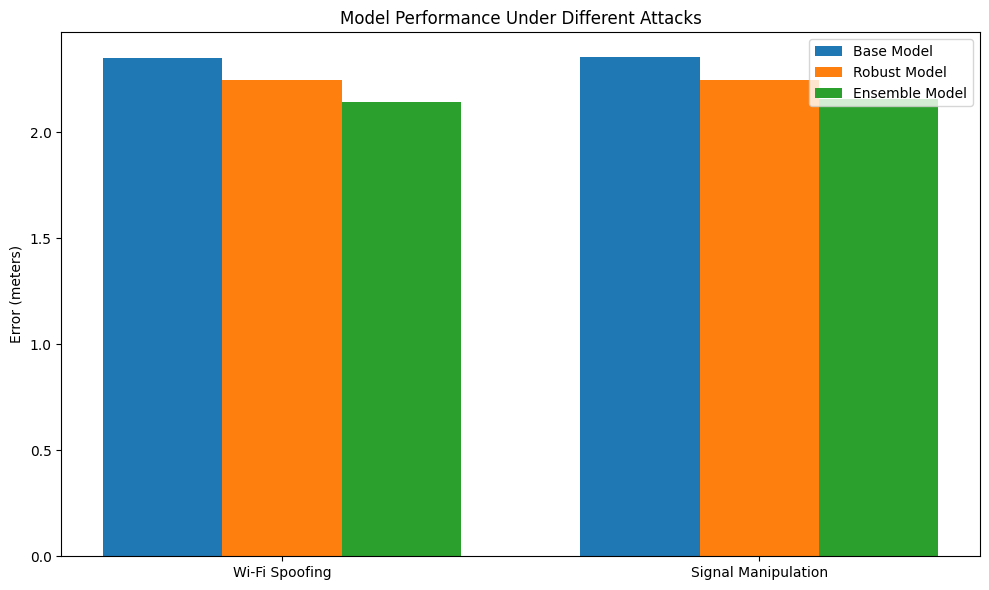

In [26]:
#Visualization and Analysis:
import matplotlib.pyplot as plt

def plot_error_comparison(base_errors, robust_errors, ensemble_errors):
    labels = ['Wi-Fi Spoofing', 'Signal Manipulation']
    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width, base_errors, width, label='Base Model')
    ax.bar(x, robust_errors, width, label='Robust Model')
    ax.bar(x + width, ensemble_errors, width, label='Ensemble Model')

    ax.set_ylabel('Error (meters)')
    ax.set_title('Model Performance Under Different Attacks')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.tight_layout()
    plt.show()

plot_error_comparison([base_spoofing_error, base_manipulation_error],
                      [robust_spoofing_error, robust_manipulation_error],
                      [ensemble_spoofing_error, ensemble_manipulation_error])

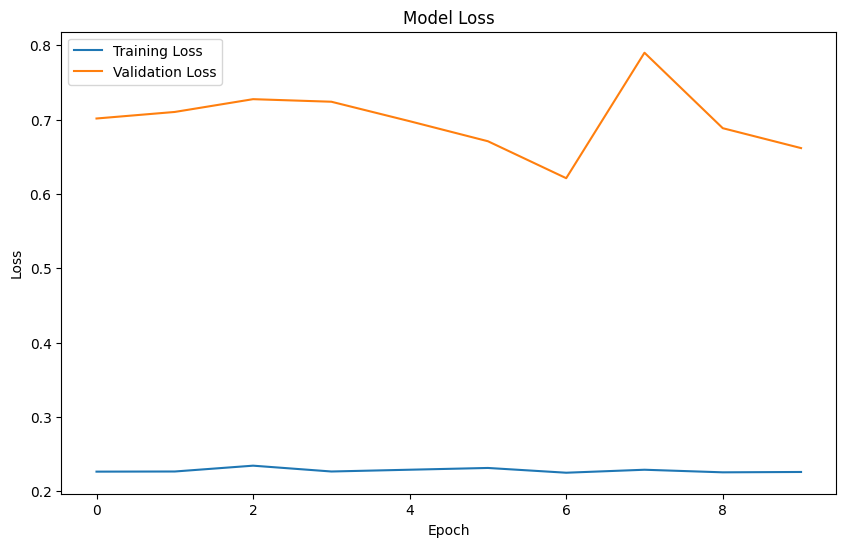

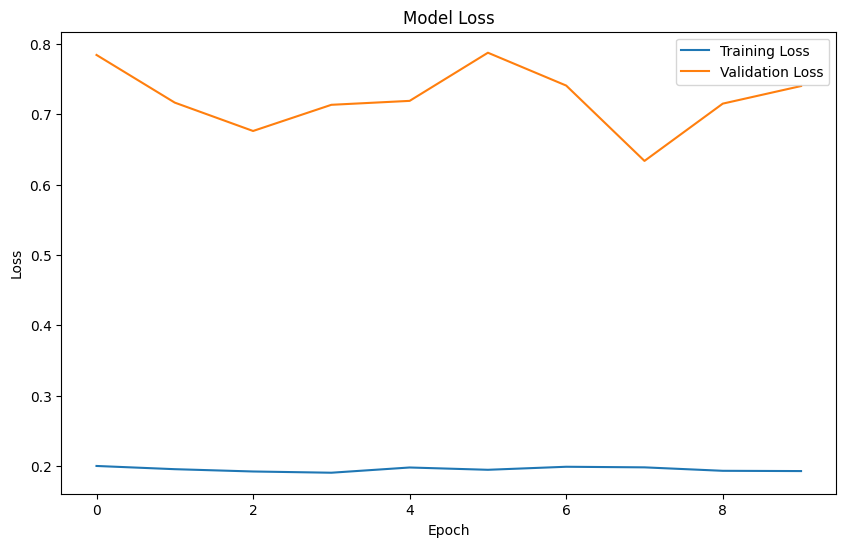

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Learning Curves
def plot_learning_curves(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=epochs, batch_size=batch_size, verbose=0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot learning curves for base model and robust model
plot_learning_curves(base_model, X_train_scaled, y_train, X_test_scaled, y_test)
plot_learning_curves(robust_model, X_train_scaled, y_train, X_test_scaled, y_test)

390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


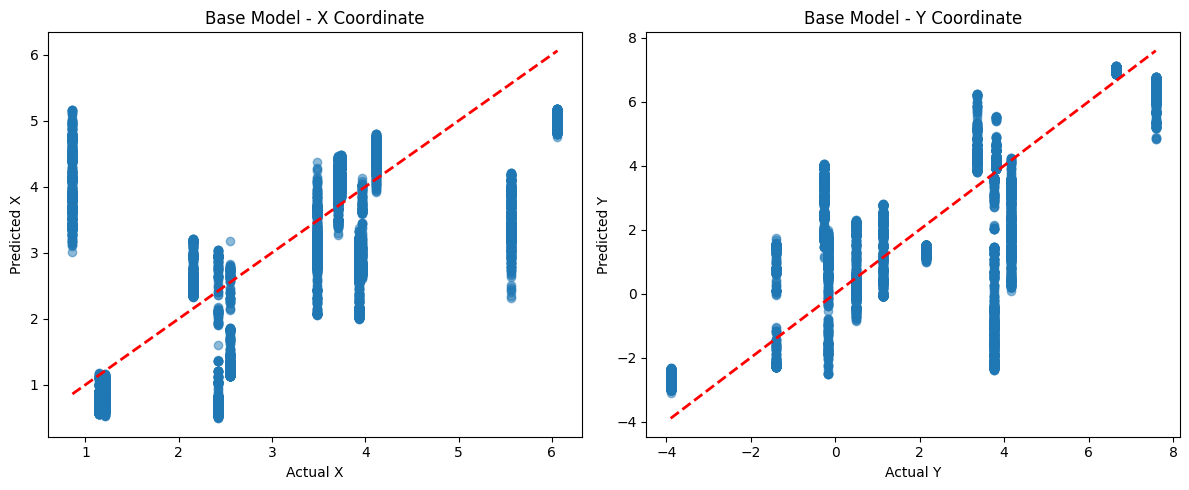

390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


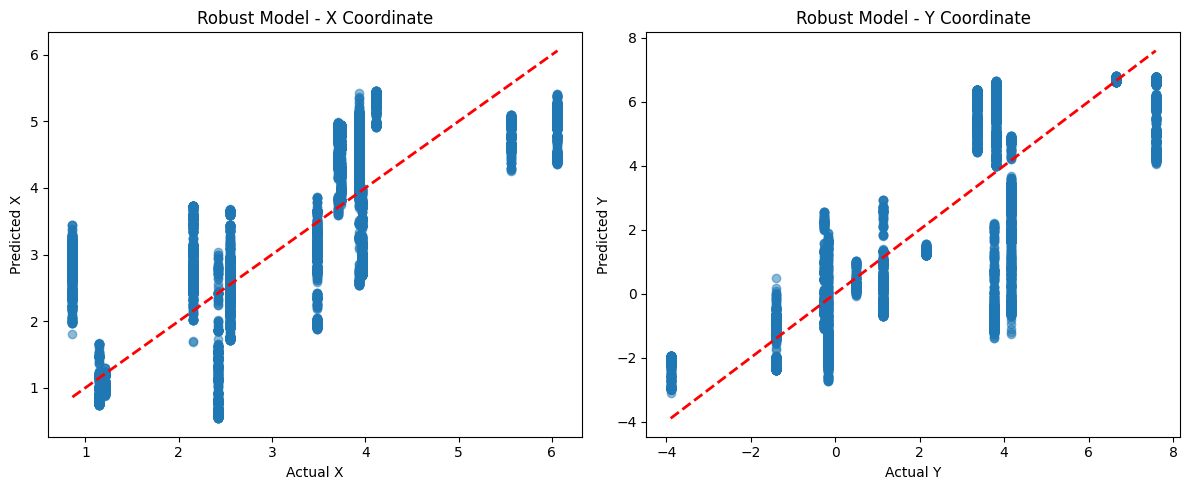

390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


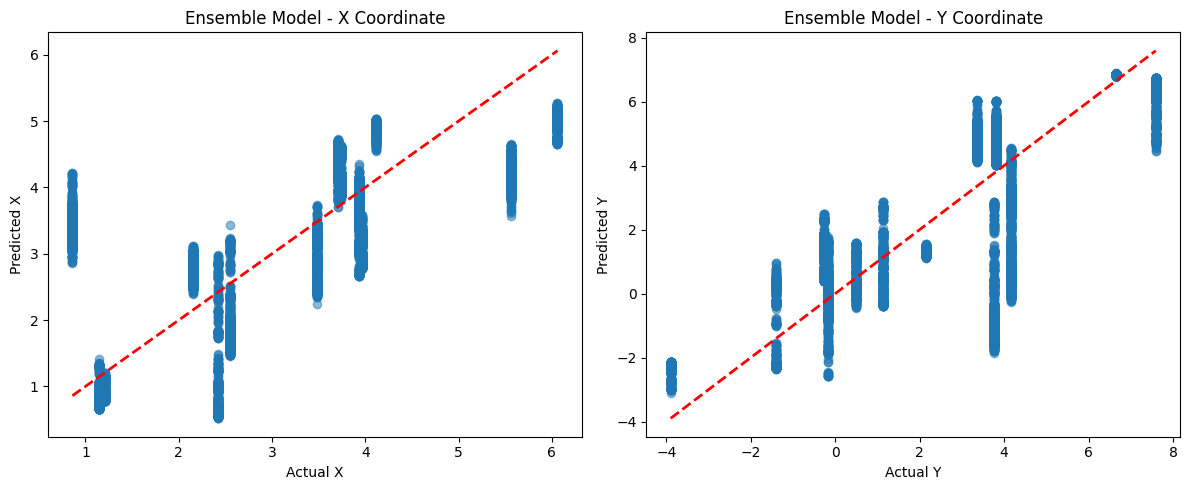

In [29]:
def plot_prediction_vs_actual(model, X, y, title):
    predictions = model.predict(X)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y.iloc[:, 0], predictions[:, 0], alpha=0.5)
    plt.plot([y.iloc[:, 0].min(), y.iloc[:, 0].max()], [y.iloc[:, 0].min(), y.iloc[:, 0].max()], 'r--', lw=2)
    plt.xlabel('Actual X')
    plt.ylabel('Predicted X')
    plt.title(f'{title} - X Coordinate')
    
    plt.subplot(1, 2, 2)
    plt.scatter(y.iloc[:, 1], predictions[:, 1], alpha=0.5)
    plt.plot([y.iloc[:, 1].min(), y.iloc[:, 1].max()], [y.iloc[:, 1].min(), y.iloc[:, 1].max()], 'r--', lw=2)
    plt.xlabel('Actual Y')
    plt.ylabel('Predicted Y')
    plt.title(f'{title} - Y Coordinate')
    
    plt.tight_layout()
    plt.show()

# Plot prediction vs actual for all models
plot_prediction_vs_actual(base_model, X_test_scaled, y_test, 'Base Model')
plot_prediction_vs_actual(robust_model, X_test_scaled, y_test, 'Robust Model')
plot_prediction_vs_actual(ensemble_model, X_test_scaled, y_test, 'Ensemble Model')

390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


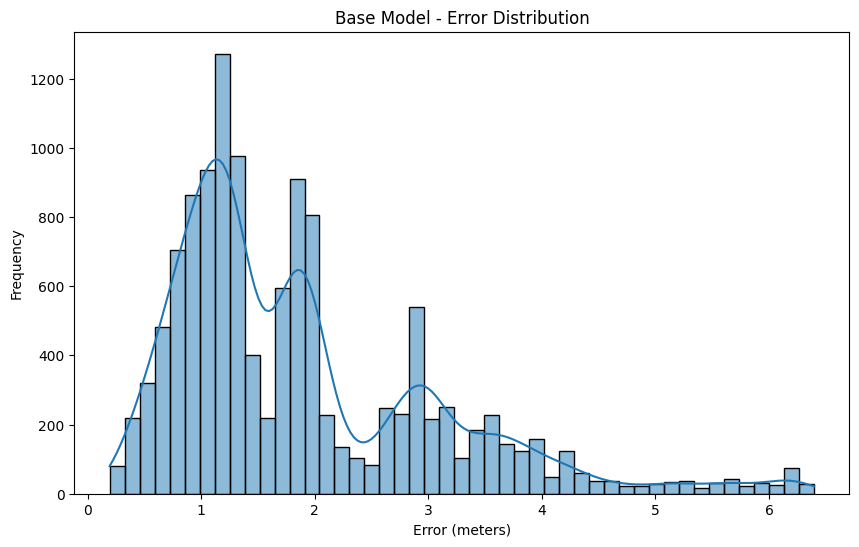

390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


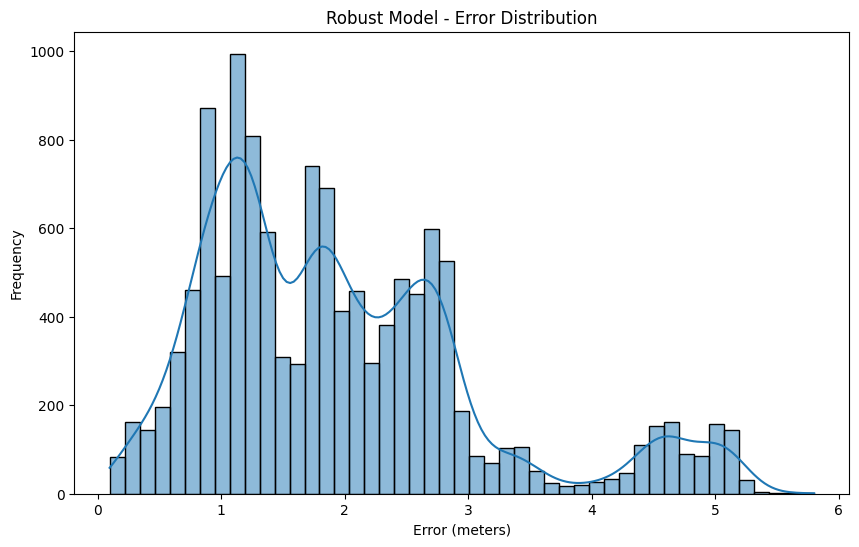

390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


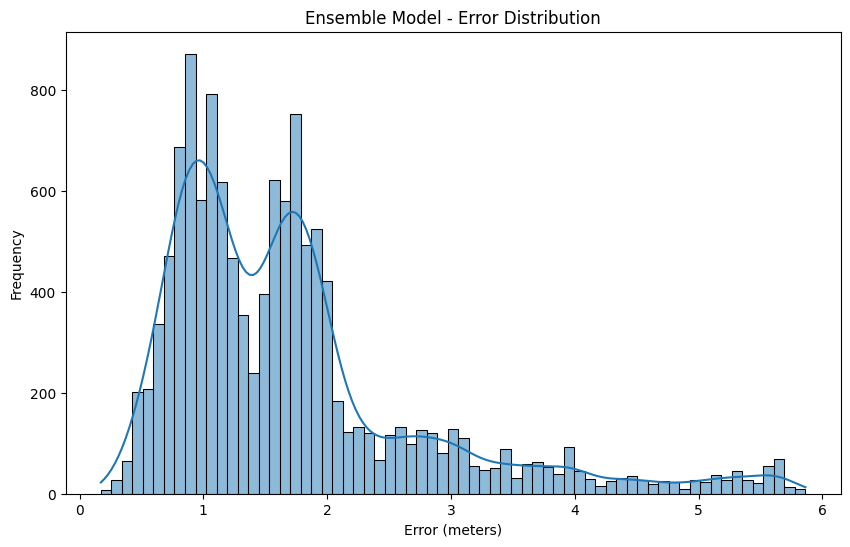

In [30]:
def plot_error_distribution(model, X, y, title):
    predictions = model.predict(X)
    errors = np.sqrt(np.sum((y.values - predictions)**2, axis=1))
    
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True)
    plt.title(f'{title} - Error Distribution')
    plt.xlabel('Error (meters)')
    plt.ylabel('Frequency')
    plt.show()

# Plot error distribution for all models
plot_error_distribution(base_model, X_test_scaled, y_test, 'Base Model')
plot_error_distribution(robust_model, X_test_scaled, y_test, 'Robust Model')
plot_error_distribution(ensemble_model, X_test_scaled, y_test, 'Ensemble Model')

390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


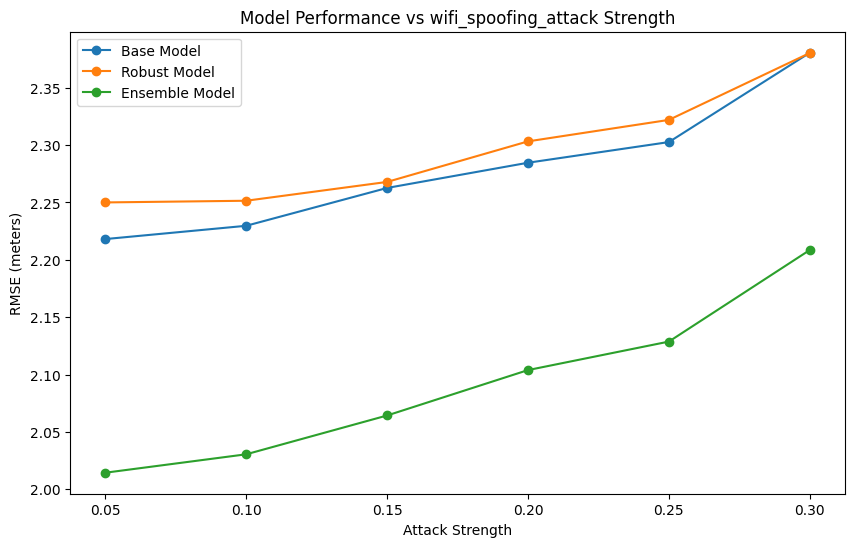

390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


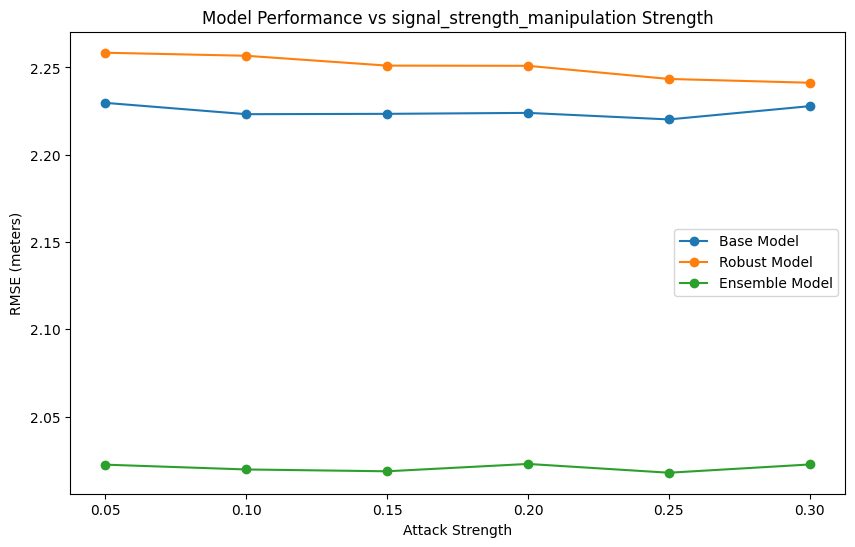

In [31]:
def compare_model_performance(models, X, y, attack_func, strengths):
    results = {model.name: [] for model in models}
    for strength in strengths:
        X_attacked = attack_func(X, strength)
        for model in models:
            predictions = model.predict(X_attacked)
            error = np.sqrt(np.mean(np.sum((y.values - predictions)**2, axis=1)))
            results[model.name].append(error)
    
    plt.figure(figsize=(10, 6))
    for model_name, errors in results.items():
        plt.plot(strengths, errors, marker='o', label=model_name)
    
    plt.xlabel('Attack Strength')
    plt.ylabel('RMSE (meters)')
    plt.title(f'Model Performance vs {attack_func.__name__} Strength')
    plt.legend()
    plt.show()

# Compare model performances
base_model.name = 'Base Model'
robust_model.name = 'Robust Model'
ensemble_model.name = 'Ensemble Model'
models = [base_model, robust_model, ensemble_model]

strengths = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
compare_model_performance(models, X_test_scaled, y_test, wifi_spoofing_attack, strengths)
compare_model_performance(models, X_test_scaled, y_test, signal_strength_manipulation, strengths)